In [48]:
%pip install tensorflow==2.11.0 tensorflow-io matplotlib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [49]:
%pip list

Package                      Version
---------------------------- ---------
absl-py                      2.0.0
asttokens                    2.4.0
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.3.0
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.1
cycler                       0.12.0
debugpy                      1.8.0
decorator                    5.1.1
exceptiongroup               1.1.3
executing                    2.0.0
flatbuffers                  23.5.26
fonttools                    4.43.0
gast                         0.4.0
google-auth                  2.23.2
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.59.0
h5py                         3.9.0
idna                         3.4
ipykernel                    6.25.2
ipython                      8.16.1
jedi

You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [50]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [51]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [52]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [53]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

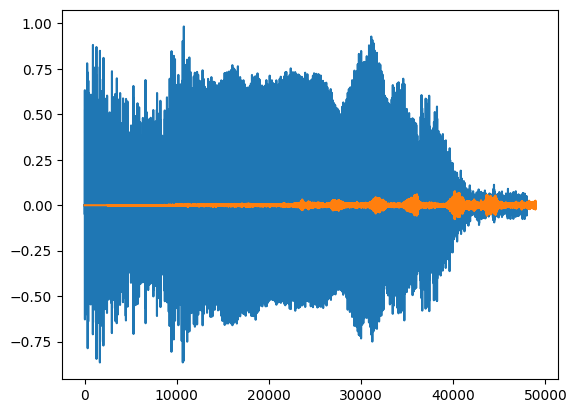

In [54]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [55]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [56]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [57]:
pos.as_numpy_iterator().next()

b'data\\Parsed_Capuchinbird_Clips\\XC216012-17.wav'

In [58]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [59]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [60]:
def preprocess(path, label):
  wav = load_wav_16k_mono(path)
  wav = wav[:48000]
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav], 0)
  spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis=2)
  return spectogram, label

In [61]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

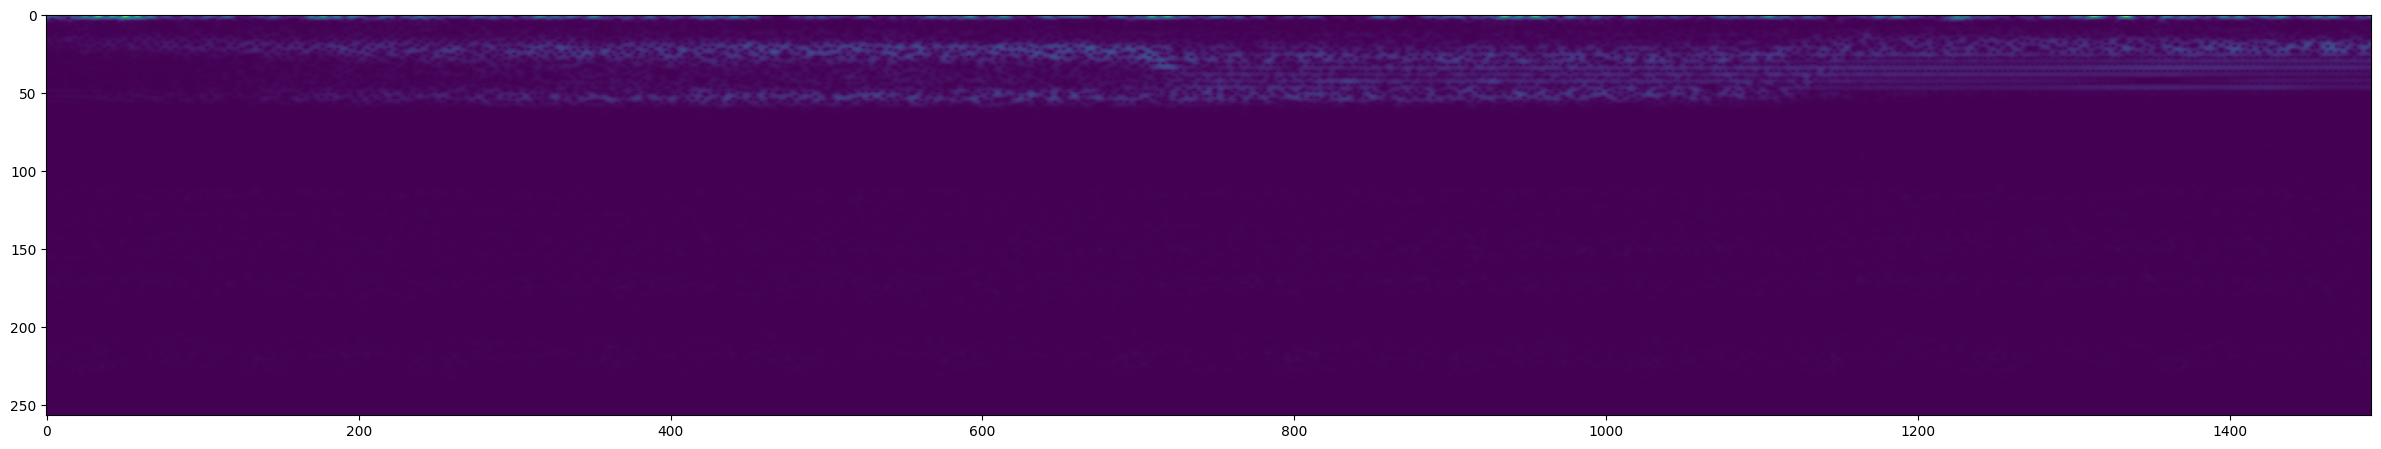

In [62]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [63]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [64]:
train = data.take(36)
test = data.skip(36).take(15)

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [75]:
model = Sequential()

In [76]:
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [77]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 368032)            0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [80]:
hist = model.fit(train, epochs=6, validation_data=test)

Epoch 1/6
36/36 [==============================] - 93s 3s/step - loss: 0.4206 - recall_1: 0.9116 - precision_1: 0.9306 - val_loss: 0.0975 - val_recall_1: 1.0000 - val_precision_1: 0.9524
Epoch 2/6
36/36 [==============================] - 92s 3s/step - loss: 0.0492 - recall_1: 0.9673 - precision_1: 0.9610 - val_loss: 0.0208 - val_recall_1: 0.9848 - val_precision_1: 0.9848
Epoch 3/6
36/36 [==============================] - 92s 3s/step - loss: 0.0279 - recall_1: 0.9864 - precision_1: 0.9864 - val_loss: 0.0163 - val_recall_1: 1.0000 - val_precision_1: 0.9839
Epoch 4/6
36/36 [==============================] - 92s 3s/step - loss: 0.0048 - recall_1: 1.0000 - precision_1: 1.0000 - val_loss: 0.0086 - val_recall_1: 0.9839 - val_precision_1: 1.0000
Epoch 5/6
36/36 [==============================] - 93s 3s/step - loss: 0.0022 - recall_1: 1.0000 - precision_1: 1.0000 - val_loss: 0.0090 - val_recall_1: 1.0000 - val_precision_1: 0.9846
Epoch 6/6
36/36 [==============================] - 92s 3s/step - 

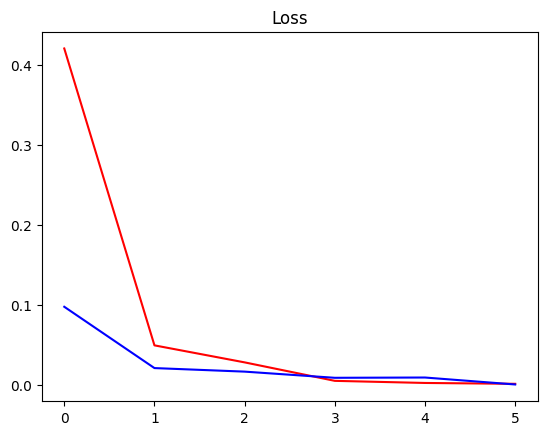

In [81]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

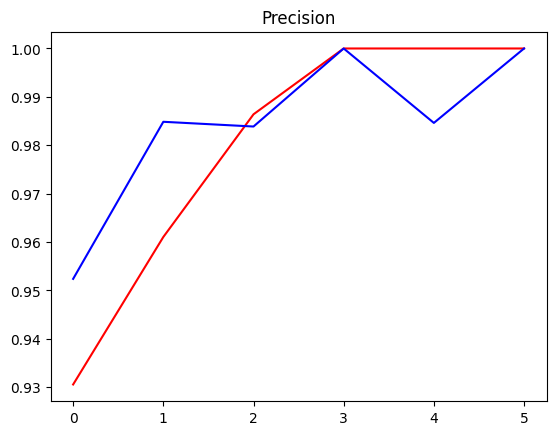

In [84]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

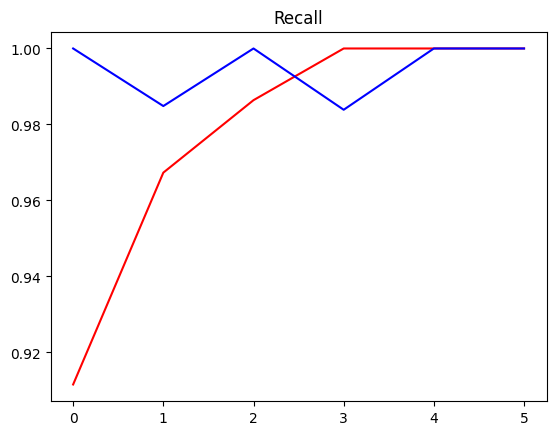

In [85]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

In [86]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [87]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')
wav = load_mp3_16k_mono(mp3)

audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav,sequence_length=48000, sequence_stride=48000, batch_size=1)

samples, index = audio_slices.as_numpy_iterator().next()


In [88]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [92]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [96]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.85 else 0 for prediction in yhat]

1/1 [==============================] - 2s 2s/step


In [97]:
from itertools import groupby

yhat = [k for k, g in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [99]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 2s 2s/step


In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [102]:
import csv

with open('capuchin_birds.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [105]:
import pandas as pd

df = pd.read_csv('capuchin_birds.csv')
df

,recording,capuchin_calls
0,recording_00.mp3,5
1,recording_01.mp3,0
2,recording_02.mp3,0
3,recording_03.mp3,0
4,recording_04.mp3,4
...,...,...
95,recording_95.mp3,5
96,recording_96.mp3,1
97,recording_97.mp3,4
98,recording_98.mp3,20


In [106]:
model.save('capuchin_birds.h5')